In [5]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [10]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [11]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [12]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [13]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

### Precipitation Analysis

* Design a query to retrieve the last 12 months of precipitation data.
* Select `date` and `prcp` values.
* Load the query results into a Pandas DataFrame.
* Plot the results using the DataFrame `plot` method.

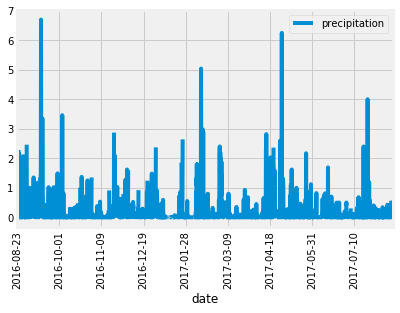

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the last data point in the database. 

# Calculate the date one year from the last date in data set (August 23, 2018).
prev_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= prev_year).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns=['date', 'precipitation'])
df.set_index(df['date'], inplace=True)
df = df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(rot=90)

### Station Analysis
* Calculate the total number of stations.
* Find the most active stations.
* Design a query to retrieve the last 12 months of temperature observation data (tobs).

In [16]:
# How many stations are available in this dataset?
session.query(func.count(Station.station)).all()

[(9)]

In [17]:
# What are the most active stations?
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Retrieve the lowest, highest and average temperature recorded of the most active station
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

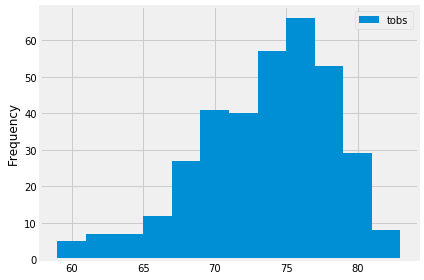

In [27]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
import datetime as dt
from pandas.plotting import table
prev_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

results = session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= prev_year).all()
df = pd.DataFrame(results, columns=['tobs'])
df.plot.hist(bins=12)
plt.tight_layout()

### Temperature Analysis
* Create a function that takes two arguments: start date and end date in the format `%Y-%m-%d` and return the minimum, average, and maximum temperatures for that range of dates.
* Use the function to calculate the min, avg, and max temperatures for the trip using the matching dates from the previous year 
    * i.e., using "2017-01-01" if the trip start date was "2018-01-01".
* Plot the min, avg, and max temperature from your previous query as a bar chart.
  * Use the average temperature as the bar height.
  * Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr).

In [29]:
# Function that takes start and end date as arguments and return minimum, average and maximum in that range 
def calc_temps(start_date, end_date):
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [47]:
# Calculate min, avg and max for the trip using the previous year's data for those same dates.
import datetime as dt

prev_year_start = dt.date(2018, 6, 1) - dt.timedelta(days=365)
prev_year_end = dt.date(2018, 6, 20) - dt.timedelta(days=365)

tmin, tavg, tmax = calc_temps(prev_year_start.strftime("%Y-%m-%d"), prev_year_end.strftime("%Y-%m-%d"))[0]
print(tmin, tavg, tmax)

72.0 77.23255813953489 83.0


/Users/marcosolorzanobaez/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


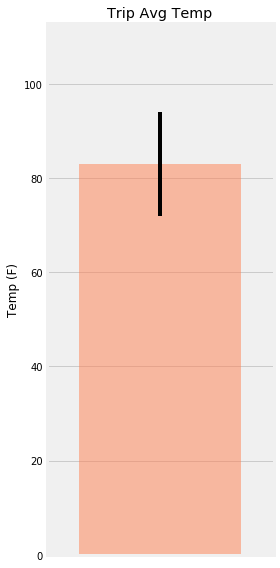

In [51]:
# Previous query results plot as an error bar chart.
# Using the average temperature for the y value and the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

fig, ax = plt.subplots(figsize=plt.figaspect(2.))
xpos = 1
yerr = tmax-tmin

bar = ax.bar(xpos, tmax, yerr=yerr, alpha=0.5, color='coral', align="center")
ax.set(xticks=range(xpos), xticklabels="a", title="Trip Avg Temp", ylabel="Temp (F)")
ax.margins(.2, .2)
# fig.autofmt_xdate()
fig.tight_layout()
fig.show()

In [70]:
# Total amount of rainfall per weather station for the trip dates 

start_date = '2017-06-01'
end_date = '2017-06-20'

sel = [Station.station, Station.name, Station.latitude, 
       Station.longitude, Station.elevation, func.sum(Measurement.prcp)]

results = session.query(*sel).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date).\
    group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()
df = pd.DataFrame(results, columns=['Station', 'Station Name','Latitude','Longitude','Elevation','Precipitation Sum'])
df.head()

,Station,Station Name,Latitude,Longitude,Elevation,Precipitation Sum
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,7.12
1,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,3.43
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,2.68
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,2.60
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.77


### Daily Rainfall Average.

* Calculate the rainfall per weather station using the previous year's matching dates.
* Calculate the daily normals. (Normals are the averages for the min, avg, and max temperatures.)
* Create a function that will calculate the daily normals for a specific date using all historic tobs that match that date string. 
    * The date string will be in the format `%m-%d`.
* Create a list of dates for the trip. 
* Use the function to calculate the normals for each date string and append the results to a list.
* Load the list of daily normals into a Pandas DataFrame and set the index equal to the date.
* Use Pandas to plot an area plot (`stacked=False`) for the daily normals.

In [71]:
from sqlalchemy import extract
# Query to retrieve June data
june_temps = session.query(Measurement).filter(extract('month', Measurement.date) == 6)
june_temps_list = [temp.tobs for temp in june_temps]
print(np.mean(june_temps_list))
# Query to retrieve December data
dec_temps = session.query(Measurement).filter(extract('month', Measurement.date) == 12)
dec_temps_list = [temp.tobs for temp in dec_temps]
print(np.mean(dec_temps_list))

74.94411764705882
71.04152933421226


In [72]:
from scipy import stats
stats.ttest_ind(june_temps_list, dec_temps_list)

Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)

In [74]:
# Create a query that will calculate the daily normals (return a list of tuples of the daily normals)
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("06-08")

[(70.0, 75.58620689655173, 81.0)]

In [76]:
# Calculate the daily normals for the trip

# Set the start and end date of the trip
trip_start = '2018-06-01'
trip_end = '2018-06-20'
# Use the start and end date to create a range of dates
trip_dates = pd.date_range(trip_start, trip_end, freq='D')
# Stip off the year and save a list of %m-%d strings
trip_month_day = trip_dates.strftime('%m-%d')
# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for date in trip_month_day:
    normals.append(*daily_normals(date))
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'])
df['date'] = trip_dates
df.set_index(['date'],inplace=True)
df.head()

,tmin,tavg,tmax
date,,,
2018-06-01,64.0,74.614035,81.0
2018-06-02,65.0,74.400000,81.0
2018-06-03,65.0,74.034483,80.0
2018-06-04,65.0,73.818182,81.0
2018-06-05,68.0,74.854545,81.0


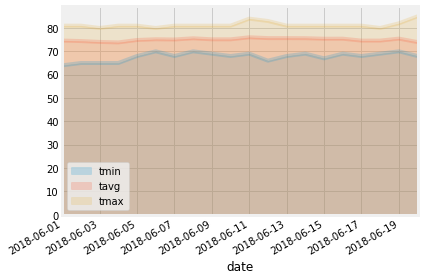

In [77]:
# Plot the daily normals as an area plot with `stacked=False`
df.plot(kind='area', stacked=False, x_compat=True, alpha=.2)
plt.tight_layout()